# COVID-19 Lung Leision Segmentation

In [6]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score

# append project directory to path
import sys
project_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(project_dir, "data")
model_dir = os.path.join(project_dir, "model")
sys.path.append(project_dir)
print(f"project directory: {project_dir}")
print(f"data directory: {data_dir}")
print(f"model directory: {model_dir}")

project directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation
data directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/data
model directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/model


In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# check gpu
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

# seeding
torch.manual_seed(4460)
np.random.seed(4460)

GPU available: True


In [9]:
from basic_dataset import BasicDataset

<b> Load Full Datasets </b>

In [10]:
train_dataset = BasicDataset(os.path.join(data_dir, 'PairedTrainData'))
valid_dataset = BasicDataset(os.path.join(data_dir, 'PairedValidData'))
test_dataset = BasicDataset(os.path.join(data_dir, 'PairedTestData'))
len(train_dataset), len(valid_dataset), len(test_dataset)

(2910, 1467, 1197)

<b> Check Data Shape </b>

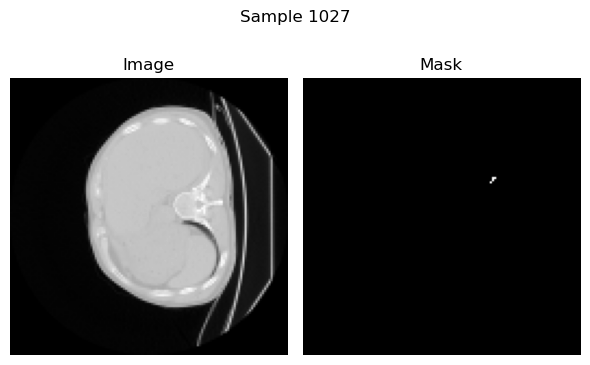

x shape: torch.Size([1, 128, 128])
y shape: torch.Size([128, 128])


In [11]:
from utils import show_pair

# show a random pair (CT image, infection mask)
sample_data = train_dataset[np.random.randint(0, len(train_dataset))]
x, y, idx = sample_data['image'], sample_data['mask'], sample_data['img_id']
show_pair(x[0], y, idx)
print(f'x shape: {x.shape}')
print(f'y shape: {y.shape}')


In [7]:
# describe image 
pd.DataFrame(x.flatten()).describe() # describe image 

,0
count,16384.000000
mean,0.262520
std,0.334055
min,0.000000
25%,0.011765
50%,0.023529
75%,0.717647
max,0.972549


In [8]:
# describe mask
pd.DataFrame(y.flatten()).describe() # describe image 

,0
count,16384.000000
mean,0.000244
std,0.015624
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<b> Show Data Split </b>

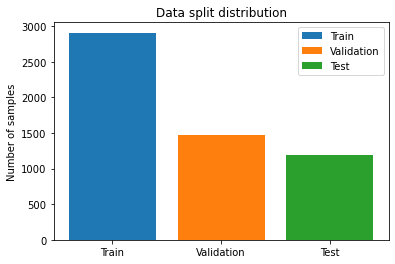

In [9]:
from utils import show_datasets

show_datasets(train_dataset, valid_dataset, test_dataset)

### Train

<b>Basic UNet-1024</b>

In [10]:
from networks import UNet, UNet_Reduced
from run_network import get_total_params

# define model
my_UNet = UNet('MyUNet', 1, 2) # output classes = 2
my_UNet.cuda()
print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

MyUNet total model parameters: 7243202


<b>Reduced UNet-256</b>

In [25]:
from networks import UNet, UNet_Reduced
from run_network import get_total_params

my_UNet = UNet_Reduced('MyUNet_red_256', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

MyUNet_red_256 total model parameters: 1813201


<b>Attention U-Net</b>

In [12]:
from networks import AttU_Net
from run_network import get_total_params

my_UNet = AttU_Net('AttU_Net', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

AttU_Net total model parameters: 34877486


<b>ResU-Net++</b>

In [ ]:
from networks import ResUnetPlusPlus
from run_network import get_total_params

my_UNet = ResUnetPlusPlus('MyUNet_red_256', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

MyUNet_red_256 total model parameters: 1813201


<b>R2AttU-Net</b>

In [20]:
from networks import R2AttU_Net
from run_network import get_total_params

my_UNet = R2AttU_Net('MyUNet_red_256', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

TypeError: not all arguments converted during string formatting

In [13]:
# Re-create train, validation, and test dataset instances to reduce the number of samples and expedite the training process.
train_dataset = BasicDataset(os.path.join(data_dir, 'PairedTrainData'), n_sample=2000)
valid_dataset = BasicDataset(os.path.join(data_dir, 'PairedValidData'), n_sample=400)
test_dataset = BasicDataset(os.path.join(data_dir, 'PairedTestData'), n_sample=400)

train_dataloader = DataLoader(train_dataset, batch_size=8, num_workers=4, pin_memory=True, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=4, pin_memory=True)

<b>Initial Weights </b>

Although we have not trained our model, we may see the output with random weights. Thus, we will pull a batch of test data loader, get the network's output, and plot it.

Sample batch 'image 'shape is: torch.Size([8, 1, 128, 128])
Sample batch 'mask' shape is: torch.Size([8, 128, 128])
Predicted mask shape is: torch.Size([8, 2, 128, 128])


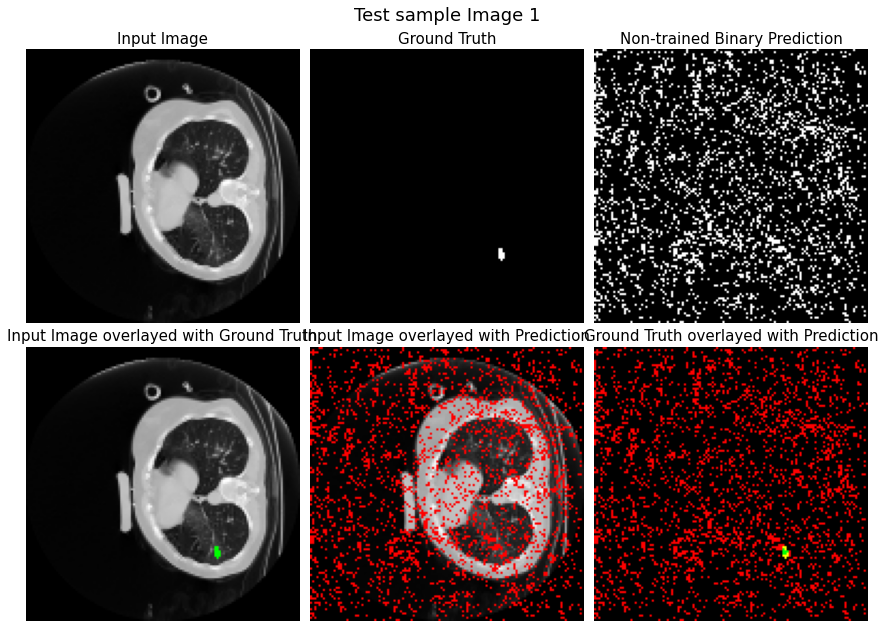

In [14]:
from utils import show_mask

show_mask(my_UNet, test_dataloader)

### 3. Train the model

In [15]:
from run_network import get_class_weight
# lr decay 
optimizer = torch.optim.Adam(my_UNet.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.5)

# use class weight for imbalanced data
class_weights = get_class_weight(train_dataset)
class_weights = torch.tensor([0.05, 1.], dtype=torch.float).cuda()
criteria = nn.CrossEntropyLoss(weight=class_weights)


In [16]:
from run_network import train_net

# train 
EPOCHS = 100
train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard = train_net(my_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, criteria, save_dir = model_dir)

trigger times: 0lidation Batch 50/50 - Loss: 0.725569, DICE score: 0.006889, Jaccard score: 0.003457            
EPOCH 1/100 - Training Loss: 0.146981, Training DICE score: 0.289879, Training Jaccard score: 0.175997, Validation Loss: 0.186198, Validation DICE score: 0.279141, Validation Jaccard score: 0.177225


### Display results

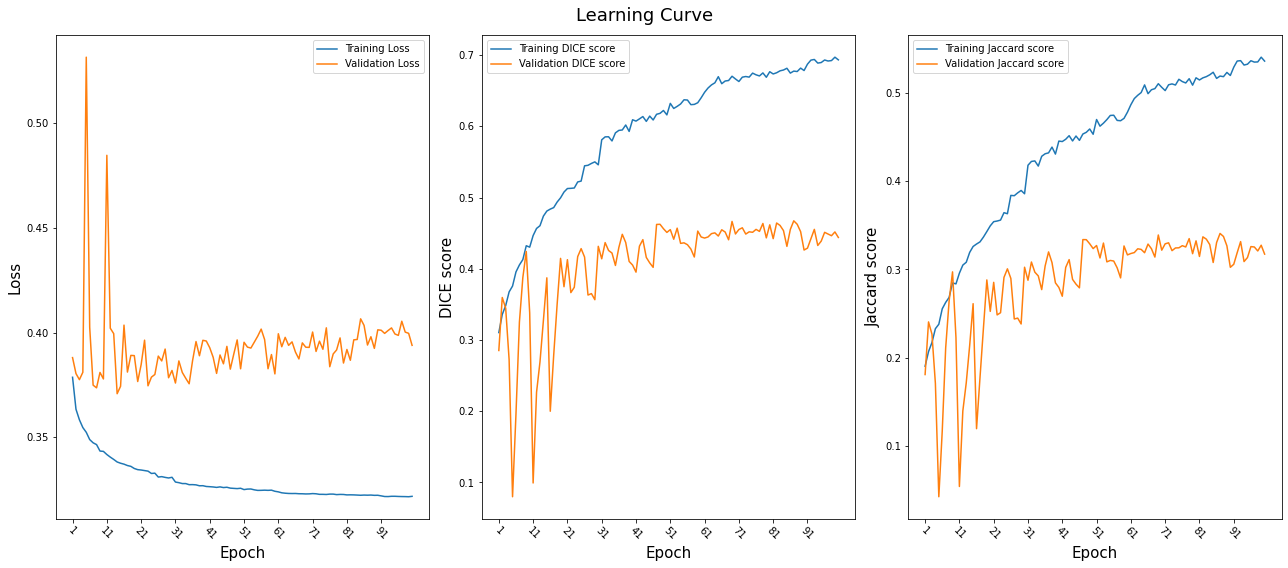

In [26]:
from run_network import show_training

show_training(EPOCHS, train_loss, valid_loss, train_dice, valid_dice, train_jaccard, valid_jaccard)

<b> Load Best Model </b>

Best epoch is epoch 185


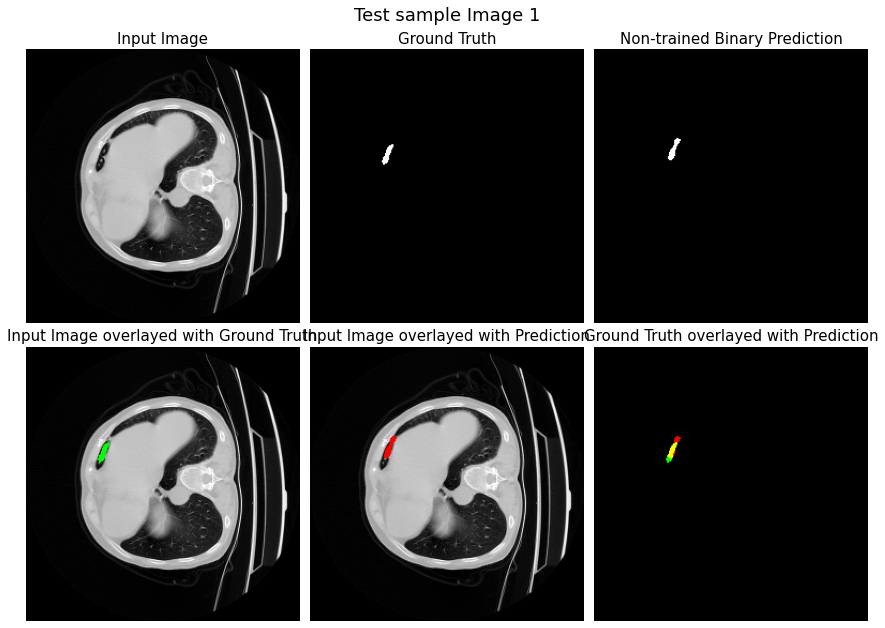

In [66]:
best_epoch = np.argmax(valid_dice) + 1 # epochs starts at 1
print(f'Best epoch is epoch {best_epoch}')

state_dict = torch.load(os.path.join(model_dir, my_UNet.name, f'epoch_{best_epoch:03}.pth'))

my_UNet.load_state_dict(state_dict)
my_UNet.cuda()

# check the performance of the best model on our previously pulled example
show_mask(my_UNet, valid_dataloader, verbose=False)

<b>Test Data </b>

In [50]:
from run_network import test_net
best_epoch = 80
state_dict = torch.load(os.path.join(model_dir, my_UNet.name, f'epoch_{best_epoch:03}.pth'))

my_UNet.load_state_dict(state_dict)
my_UNet.cuda()

# run best model on testdata
test_loss, test_dice, test_jaccard, test_accuracy, test_CM = test_net(my_UNet, test_dataloader, criteria, save_dir=model_dir)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Jaccard score: {test_jaccard}, Test overall accuracy: {test_accuracy}')

Test Loss: 0.493017262617747, Test DICE score: 0.46605178713798523, Test Jaccard score: 0.33407023549079895, Test overall accuracy: 0.99078914642333986


Text(0.5, 69.0, 'predicted labels')

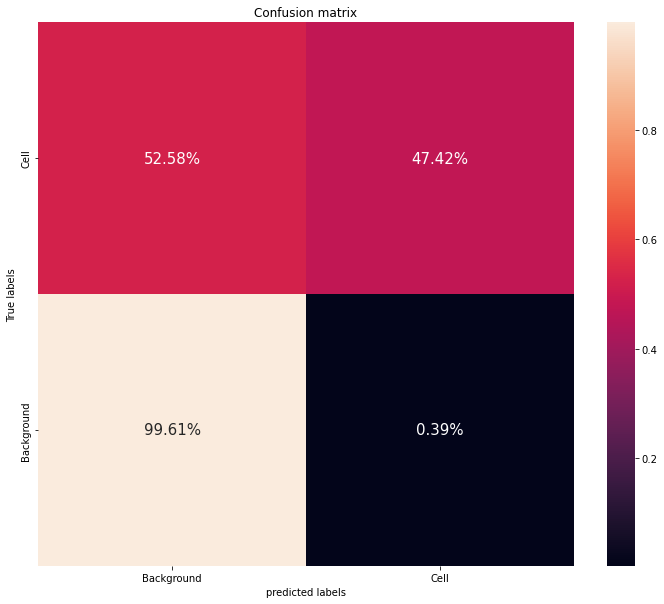

In [48]:
# confusion matrix
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2])
plt.ylabel('True labels')
plt.xlabel('predicted labels')